## Model III

* **Norms**: McRae et al. (2005)

* **Model**: Simple Model Inspired by Erk (2016) Examples
    * Idea: The properties of an unknown word are informed by its position in its argument structure (core or core + peripheral).
    * Scope (current model): Only core-argument positions.
    * Probability for a New Word $w$ to have $prop$: Let $v$ be the predicate, then
        * General: $p_{subj}(prop\mid v) \propto \sum_{subj\in v_{subj}}p(prop\mid subj)p(subj\mid v)$, similar for $obj$.
        * Specific: $p_{subj}(prop\mid v,obj) \propto \sum_{subj\in v_{subj}}p(prop\mid subj)p(subj\mid v,obj)$, similar for $obj$.
        * NB: $v_{subj}$ and $v_{obj}$ are cohorts of an unknown word $w$. For instance, if $w$ is 'alligator', which appears in the sentence 'a guy is feeding an alligator', then the cohort $v_obj$ would be all the objects of $v$ as appeared in a selected corpus.

* **Algorithm**:
    * Let $W$ be the set of norm nouns ($W_{subj},W_{obj}$ are subj/obj-only sets), $V$ be the set of verbs which have at least one $w\in W$ evidenced in its core argument position, $P$ be the set of properties.
    * Build cooccurrence matrices $S_{|V_{subj}|\times|W_{subj}|}$ and $O_{|V_{obj}|\times|W_{obj}|}$ from corpus.
    * Build cooccurrence matrices $S'_{|W_{subj}|\times|P|}$ and $O'_{|W_{obj}|\times|P|}$ from McRae norms.
    * Obtain distributions $p_{subj}(prop\mid v)$ or $p_{subj}(prop\mid v, o)$ (similar for $obj$) using matrices $S,S',O,O'$.
    * On encountering a new/unknown word $w_{subj}$ or $w_{obj}$ in sentence $s$ with predicate $v$,
        * Find $w$'s paradigmatic cohort, i.e. $v_{subj}$ or $v_{obj}$,
        * Compute $p_{subj}(prop\mid v)$ or $p_{subj}(prop\mid v, o)$ for $prop\in P$ using the cohort,
        * (Partial) Bayesian Update:
            * Case 1: If $w$ is completed **unseen** before, update $w$'s probability distribution over properties with this $p_{subj/obj}$.
            * Case 2: Otherwise, perform pointwise multiplication of $w$'s probability distribution over properties and the newly computed distribution, then normalize the result (i.e. expected distribution), before updating $w$'s distribution with it.
            * Notes:
                * The update is *partial*, because we only investigate the learning of a single new word in a few examples, but leave the trained "information/knowledge state" unupdated.
                * Note that *unseen* is not *unknown*. For instance, despite the fact I've seen 'elm' appearing multiple times, I cannot point to an object and call it 'elm'. 'elm' is therefore an unknown, but not unseen, word to me.
    * Evaluation: Return top $k$ $prop$s as a hypothesis for $w$'s property set.

* **Comments**:
    * $p_{subj}(prop\mid v, o)$ could be an immensely sparse distribution.
    * If we had higher coverage on noun properties, taking the insersection of properties for $v_{subj/obj}$ is perhaps a better reflection of our intuition -- this intersection is the common properties for words in $subj$ or $obj$ position of $v$.

## 0. Load Corpora

### A. Norms

In [1]:
import pandas as pd

In [2]:
data_path = "/Users/jacobsw/Desktop/CODER/IMPLEMENTATION_CAMP/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/DATA/McRae-BRM-InPress/"

In [3]:
df = pd.read_csv(data_path+"CONCS_FEATS_concstats_brm.xls", delimiter='\t')

In [4]:
print df.columns

Index([u'Concept', u'Feature', u'WB_Label', u'WB_Maj', u'WB_Min', u'BR_Label',
       u'Prod_Freq', u'Rank_PF', u'Sum_PF_No_Tax', u'CPF', u'Disting',
       u'Distinct', u'CV_No_Tax', u'Intercorr_Str_Tax',
       u'Intercorr_Str_No_Tax', u'Feat_Length_Including_Spaces', u'Phon_1st',
       u'KF', u'ln(KF)', u'BNC', u'ln(BNC)', u'Familiarity', u'Length_Letters',
       u'Length_Phonemes', u'Length_Syllables', u'Bigram', u'Trigram',
       u'ColtheartN', u'Num_Feats_Tax', u'Num_Feats_No_Tax',
       u'Num_Disting_Feats_No_Tax', u'Disting_Feats_%_No_Tax',
       u'Mean_Distinct_No_Tax', u'Mean_CV_No_Tax', u'Density_No_Tax',
       u'Num_Corred_Pairs_No_Tax', u'%_Corred_Pairs_No_Tax', u'Num_Func',
       u'Num_Vis_Mot', u'Num_VisF&S', u'Num_Vis_Col', u'Num_Sound',
       u'Num_Taste', u'Num_Smell', u'Num_Tact', u'Num_Ency', u'Num_Tax'],
      dtype='object')


In [122]:
df.head(10)

,Concept,Feature,WB_Label,WB_Maj,WB_Min,BR_Label,Prod_Freq,Rank_PF,Sum_PF_No_Tax,CPF,...,Num_Func,Num_Vis_Mot,Num_VisF&S,Num_Vis_Col,Num_Sound,Num_Taste,Num_Smell,Num_Tact,Num_Ency,Num_Tax
0,accordion,a_musical_instrument,superordinate,c,h,taxonomic,28,1,NaN,18,...,2,0,2,0,2,0,0,0,2,1
1,accordion,associated_with_polkas,associated_entity,s,e,encyclopaedic,9,4,9.0,1,...,2,0,2,0,2,0,0,0,2,1
2,accordion,has_buttons,external_component,e,ce,visual-form_and_surface,8,5,163.0,13,...,2,0,2,0,2,0,0,0,2,1
3,accordion,has_keys,external_component,e,ce,visual-form_and_surface,17,2,108.0,7,...,2,0,2,0,2,0,0,0,2,1
4,accordion,inbeh_-_produces_music,entity_behavior,e,b,sound,6,7,178.0,13,...,2,0,2,0,2,0,0,0,2,1
5,accordion,is_loud,external_surface_property,e,se,sound,6,7,317.0,34,...,2,0,2,0,2,0,0,0,2,1
6,accordion,requires_air,contingency,i,c,encyclopaedic,11,3,49.0,4,...,2,0,2,0,2,0,0,0,2,1
7,accordion,used_by_moving_bellows,action,s,a,function,8,5,8.0,1,...,2,0,2,0,2,0,0,0,2,1
8,accordion,worn_on_chest,function,s,f,function,6,7,6.0,1,...,2,0,2,0,2,0,0,0,2,1
9,airplane,beh_-_flies,entity_behavior,e,b,visual-motion,25,1,712.0,46,...,3,3,5,0,0,0,0,0,2,0


### B. Brown

In [7]:
from nltk.corpus import brown
from spacy.en import English

In [8]:
parser = English()

In [9]:
brown_sents = [unicode(' '.join(sent)) for sent in brown.sents()]

In [10]:
%%time
parsed_sents = [parser(sent) for sent in brown_sents]

CPU times: user 1min 34s, sys: 806 ms, total: 1min 35s
Wall time: 1min 35s


In [12]:
def make_token2lemma_dict(parsed_sents):
    
    lemmas = set()
    token2lemma = {}
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            token2lemma[token.orth_] = token.lemma_
            lemmas.add(token.lemma_)
    
    return lemmas, token2lemma

In [13]:
%%time
brown_lemmas, brown_t2l = make_token2lemma_dict(parsed_sents)

CPU times: user 1.2 s, sys: 19.1 ms, total: 1.22 s
Wall time: 1.22 s


In [14]:
print brown_t2l['books']

book


### C. Synchronize Norms & Brown

In [455]:
norms = {df.ix[i]['Concept'] for i in range(df.shape[0])}

In [456]:
def norm_normalize(norm):
    
    norm = norm.split('_')[0] if '_' in norm else norm
    if norm in brown_t2l: return brown_t2l[norm]
    return norm


In [457]:
print norm_normalize('cat_(kitchen)')
print norm_normalize('cat')

cat
cat


In [458]:
# Count Out-Of-Vocab Norms For Brown
t = [] 
for norm in norms:
    norm = norm.split('_')[0] if '_' in norm else norm
    if norm in brown_lemmas or norm in brown_t2l: continue
    t.append(norm)

In [459]:
print t
print len(t)

['earmuffs', 'bike', 'screwdriver', 'unicycle', 'camisole', 'crossbow', 'hamster', 'bra', 'sledgehammer', 'skateboard', 'leotards', 'rhubarb', 'platypus', 'pelican', 'minnow', 'canary', 'spatula', 'motorcycle', 'iguana', 'chickadee', 'giraffe', 'tricycle', 'bazooka', 'tomahawk', 'ostrich', 'cucumber', 'lettuce', 'whale', 'stork', 'bluejay', 'colander', 'chipmunk', 'escalator', 'partridge', 'parka', 'zucchini', 'dunebuggy', 'machete', 'crowbar', 'housefly', 'blender', 'nectarine', 'scooter', 'cougar', 'penguin', 'emu', 'honeydew', 'wheelbarrow', 'harmonica', 'eggplant', 'groundhog', 'harpoon', 'yam', 'squid', 'toaster', 'moose', 'tuna', 'surfboard', 'nylons', 'raven', 'budgie', 'fridge', 'gopher', 'flamingo', 'sleigh', 'trombone', 'strainer', 'dagger', 'chimp', 'buzzard', 'guppy', 'grater', 'nightgown', 'cello', 'hornet', 'finch', 'tangerine', 'gorilla', 'caribou']
79


** SPECIAL BLOCK: FOR LEAVE-ONE-OUT **

In [315]:
# out_word = 'alligator'
# norms = filter(lambda norm: norm!=out_word, map(lambda norm:norm_normalize(norm), norms))

In [460]:
norms = map(lambda norm:norm_normalize(norm), norms)

In [461]:
norms_set = set(norms) # for faster lookup

## I. Build $S,S'$ & $O,O'$

### A. $W_{subj}, W_{obj}$ & $V_{subj}, V_{obj}$

In [462]:
def extract_dep_triples(parsed_sents):
    
    triples = []
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            lemma_triple = (token.lemma_, token.dep_, token.head.lemma_)
            triples.append(lemma_triple)
    
    return triples

In [463]:
%%time
dep_triples = extract_dep_triples(parsed_sents)

CPU times: user 1.05 s, sys: 30.1 ms, total: 1.08 s
Wall time: 1.07 s


In [464]:
def get_w_set(triples, mode):
    
    w_set = set()
    for triple in triples:
        if triple[1].endswith(mode) and triple[0] in norms_set:
            w_set.add(triple[0])
    
    return w_set
    

In [465]:
%%time
W_subj = get_w_set(dep_triples, mode='subj')
W_obj = get_w_set(dep_triples, mode='obj')

CPU times: user 770 ms, sys: 6.93 ms, total: 777 ms
Wall time: 776 ms


In [466]:
print len(W_subj), len(W_obj)
print len(W_subj.intersection(W_obj))

232 394
221


In [467]:
def get_v_set(triples, mode):
    
    v_set = set()
    for triple in triples:
        if triple[1].endswith(mode) and triple[0] in norms_set:
            v_set.add(triple[2])
    
    return v_set


In [468]:
%%time
V_subj = get_v_set(dep_triples, 'subj')
V_obj = get_v_set(dep_triples, 'obj')

CPU times: user 766 ms, sys: 11 ms, total: 777 ms
Wall time: 771 ms


In [469]:
print len(V_subj), len(V_obj)
print len(V_subj.intersection(V_obj))

414 619
188


### B. $S$ & $O$

In [470]:
import numpy as np

In [471]:
vsubj2i = {v:i for i,v in enumerate(list(V_subj))}
vobj2i = {v:i for i,v in enumerate(list(V_obj))}
subj2i = {subj:i for i,subj in enumerate(list(W_subj))}
obj2i = {obj:i for i,obj in enumerate(list(W_obj))}

In [472]:
print len(vsubj2i), len(vobj2i), len(subj2i), len(obj2i)

414 619 232 394


In [473]:
def get_corpus_mat(triples, v2i, w2i, mode):
    
    corpus_mat = np.zeros((len(v2i),len(w2i)))
    for triple in triples:
        if triple[1].endswith(mode) and triple[0] in norms_set:
            corpus_mat[v2i[triple[2]]][w2i[triple[0]]] += 1
    
    return corpus_mat
    

In [474]:
%%time
S = get_corpus_mat(dep_triples, vsubj2i, subj2i, 'subj')
O = get_corpus_mat(dep_triples, vobj2i, obj2i, 'obj')

CPU times: user 789 ms, sys: 26.2 ms, total: 815 ms
Wall time: 800 ms


In [475]:
print S.shape, O.shape

(414, 232) (619, 394)


### C. $S'$ & $O'$

In [476]:
from collections import defaultdict

In [477]:
features = {df.ix[i]['Feature'] for i in range(df.shape[0])}
f2i = {f:i for i,f in enumerate(features)}

In [478]:
feature_list = list(features)

In [479]:
def make_norm2feature_dict(df, w_set):
    
    norm2feature = defaultdict(int)
    for i in xrange(df.shape[0]):
        norm = norm_normalize(df.ix[i]['Concept'])
        if norm in w_set:
            prop = df.ix[i]['Feature']
            norm2feature[(norm,prop)] = df.ix[i]['Prod_Freq'] # production frequency.
    
    return norm2feature

In [480]:
print df.ix[0]['Concept']
print df.ix[0]['Feature']
print df.ix[0]['Prod_Freq']

accordion
a_musical_instrument
28


In [481]:
%%time
subjft_dict = make_norm2feature_dict(df, W_subj)
objft_dict = make_norm2feature_dict(df, W_obj)

CPU times: user 5.53 s, sys: 72.8 ms, total: 5.6 s
Wall time: 5.57 s


In [482]:
subjft_dict[('airplane','is_fast')]

11

In [483]:
for prop in features:
    count = subjft_dict[('airplane',prop)]
    if count!=0: print prop, count

used_for_transportation 10
is_fast 11
used_for_travel 7
has_a_propeller 5
has_wings 20
beh_-_flies 25
is_large 8
requires_pilots 11
has_engines 5
used_for_passengers 15
found_in_airports 8
made_of_metal 8
inbeh_-_crashes 7


In [484]:
from __future__ import division

In [485]:
def make_norm_mat(wft_dict, w2i):
    
    norm_mat = np.zeros((len(w2i),len(f2i)))
    for w in w2i.iterkeys():
        for prop in f2i.iterkeys():
            norm_mat[w2i[w]][f2i[prop]] = wft_dict[(w,prop)]
    
    return norm_mat / 30 # cf. McRae
    

In [486]:
%%time
S_prime = make_norm_mat(subjft_dict, subj2i)
O_prime = make_norm_mat(objft_dict, obj2i)

CPU times: user 1.33 s, sys: 33.5 ms, total: 1.36 s
Wall time: 1.36 s


In [487]:
print S_prime.shape, O_prime.shape

(232, 2526) (394, 2526)


In [488]:
print S_prime[subj2i['airplane']][f2i['is_fast']]

0.366666666667


## II. Obtain Probability Distributions

### A. $p(subj/obj\mid v)$ & $p(prop\mid subj/obj)$

In [489]:
def div(x,y): return x/y if y!=0 else 0

In [490]:
def p_subj_given_v(w, v):
    return div(S[vsubj2i[v]][subj2i[w]], S[vsubj2i[v]].sum())
def p_obj_given_v(w, v):
    return div(O[vobj2i[v]][obj2i[w]], O[vobj2i[v]].sum())

In [491]:
print p_obj_given_v('crocodile', 'feed')

0.166666666667


In [492]:
def p_prop_given_subj(prop, w, binary=1):
    if binary:
        return 1 if S_prime[subj2i[w]][f2i[prop]]!=0 else 0
    return S_prime[subj2i[w]][f2i[prop]]
def p_prop_given_obj(prop, w, binary=1):
    if binary:
        return 1 if O_prime[obj2i[w]][f2i[prop]]!=0 else 0
    return O_prime[obj2i[w]][f2i[prop]]

# Comments: Binary seems to make more sense -- even if only 1 person out of 30 says 
#     a crocodile is an animal, then it should be the case that 'crocodile is an animal'
#     rather than 'crocodile has 20% chance to be an animal'.

In [493]:
print p_prop_given_obj('an_animal','crocodile')
print p_prop_given_obj('an_animal','crocodile', binary=0) 

1
0.2


### B. $p_{subj/obj}(prop\mid v) \propto \sum_{subj\in v_{subj/obj}}p(prop\mid subj/obj)p(subj/obj\mid v)$

In [494]:
def p_subj_prop_given_v(prop, v, binary=1, cohort=subj2i.keys()):
    return sum(p_prop_given_subj(prop,w,binary)*p_subj_given_v(w,v) for w in cohort)
def p_obj_prop_given_v(prop, v, binary=1, cohort=obj2i.keys()):
    return sum(p_prop_given_obj(prop,w,binary)*p_obj_given_v(w,v) for w in cohort)    

In [500]:
print p_obj_prop_given_v('an_animal','feed') # 'feed' is very specific to animals.
print p_obj_prop_given_v('an_animal','like') # 'like' has a more varied object base.
print p_obj_prop_given_v('an_animal','develop') # 'develop' cannot possibly take an animal for object.

0.666666666667
0.341772151899
0.0


## III. Infer Properties of "New Words" $w\in norms$

In [501]:
# get V:[n1...nn] dict, i.e. for paradigmatic cohort
def get_arg_list(triples, argtype): # argtype = {subj, obj}
    
    arg_list = defaultdict(list)
    for triple in triples:
        if triple[1].endswith(argtype) and triple[0] in norms_set:
            arg_list[triple[2]].append(triple[0])
    
    return arg_list

In [502]:
%%time
subj2args, obj2args = get_arg_list(dep_triples, 'subj'), get_arg_list(dep_triples, 'obj')

CPU times: user 811 ms, sys: 57.5 ms, total: 868 ms
Wall time: 854 ms


In [503]:
print obj2args['feed']

[u'pig', u'corn', u'horse', u'rice', u'crocodile', u'cat']


In [504]:
def infer_subj_properties(w, v, topk=5):
    
    cohort = subj2args[v]
    props = [p_subj_prop_given_v(prop,v,cohort) for prop in feature_list]
    topk_props_idx = np.argsort(props)[::-1][:topk]
    
    for i,idx in enumerate(topk_props_idx):
        print "%dth Property: %s (prop=%.6f%%)" % (i+1,feature_list[idx],prop[idx])

def infer_obj_properties(w, v, topk=5):
    
    cohort = obj2args[v]
    props = [p_obj_prop_given_v(prop,v,cohort) for prop in feature_list]
    topk_props_idx = np.argsort(props)[::-1][:topk]
    
    for i,idx in enumerate(topk_props_idx):
        print "%dth Property: %s (prop=%.6f%%)" % (i+1,feature_list[idx],props[idx])
        

In [505]:
infer_obj_properties('crocodile','feed')

1th Property: has_4_legs (prop=0.666667%)
2th Property: has_a_tail (prop=0.666667%)
3th Property: an_animal (prop=0.666667%)
4th Property: is_edible (prop=0.500000%)
5th Property: has_legs (prop=0.500000%)


In [506]:
infer_obj_properties('book','read')

1th Property: has_pages (prop=0.833333%)
2th Property: has_words_in_it (prop=0.833333%)
3th Property: has_authors (prop=0.833333%)
4th Property: used_for_learning (prop=0.833333%)
5th Property: has_a_hard_cover (prop=0.833333%)


## IV. Leave-One-Out Evaluation

In [586]:
import matplotlib.pyplot as plt
%matplotlib inline

### E.G. 'alligator' (Single Exposure)

In [507]:
# observed: 'a guy is feeding an alligator.'
# pred/arg: 'feed', 'alligator' as object.

# Config: SPECIAL BLOCK ACTIVATED TEMPORARILY TO LEAVE 'ALLIGATOR' OUT

In [508]:
def get_cohort(triples, v, argtype): # argtype = {subj, obj}
    
    args = []
    for triple in triples:
        if triple[1].endswith(argtype) \
            and triple[2]==v \
            and triple[0] in norms_set:
            args.append(triple[0])
    
    return args

In [509]:
def infer_unknown_properties(v, cohort, argtype, topk=5, prt=0):

    if argtype=='subj':
        props = [p_subj_prop_given_v(prop,v,cohort) for prop in feature_list]
    elif argtype=='obj':
        props = [p_obj_prop_given_v(prop,v,cohort) for prop in feature_list]
    else: raise Error
    if not prt: return props
    
    topk_props_idx = np.argsort(props)[::-1][:topk]
    for i,idx in enumerate(topk_props_idx):
        print "%dth Property: %s (prop=%.6f%%)" % (i+1,feature_list[idx],props[idx])


In [583]:
feed_obj_cohort = get_cohort(dep_triples, 'feed', 'obj')
print feed_obj_cohort, len(feed_obj_cohort)

[u'pig', u'corn', u'horse', u'rice', u'crocodile', u'cat'] 6


In [511]:
infer_unknown_properties('feed', feed_obj_cohort, argtype='obj', prt=1)

1th Property: has_4_legs (prop=0.666667%)
2th Property: has_a_tail (prop=0.666667%)
3th Property: an_animal (prop=0.666667%)
4th Property: is_edible (prop=0.500000%)
5th Property: has_legs (prop=0.500000%)


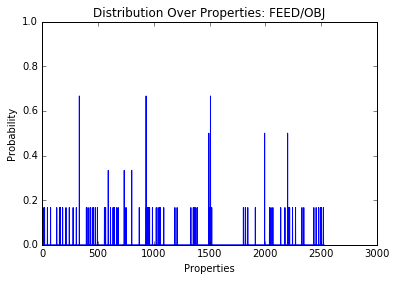

In [584]:
plt.plot(infer_unknown_properties('feed', feed_obj_cohort, argtype='obj', prt=0))
plt.title("Distribution Over Properties: FEED/OBJ")
plt.xlabel("Properties")
plt.ylabel("Probability")
plt.ylim(0,1)
plt.show()

In [512]:
# observed: 'John says he likes alligators.'
# pred/arg: 'like', 'alligator' as object.

In [582]:
be_obj_cohort = get_cohort(dep_triples, 'be', 'subj')
print be_obj_cohort, len(be_obj_cohort)

[u'submarine', u'building', u'bomb', u'lemon', u'tie', u'mat', u'church', u'stone', u'wall', u'house', u'level', u'ring', u'ball', u'house', u'missile', u'dress', u'car', u'cat', u'board', u'book', u'house', u'board', u'church', u'car', u'book', u'book', u'boat', u'dog', u'truck', u'bomb', u'bomb', u'gun', u'car', u'balloon', u'ship', u'tractor', u'piano', u'book', u'book', u'book', u'fox', u'book', u'fan', u'fan', u'chain', u'ring', u'radio', u'radio', u'key', u'dish', u'trailer', u'rock', u'church', u'chain', u'church', u'board', u'bed', u'avocado', u'avocado', u'missile', u'missile', u'missile', u'trailer', u'horse', u'gun', u'rifle', u'rifle', u'dish', u'fork', u'deer', u'bridge', u'building', u'rock', u'tripod', u'door', u'bin', u'key', u'bridge', u'bridge', u'bridge', u'bridge', u'bridge', u'bridge', u'bridge', u'bridge', u'house', u'house', u'brush', u'mat', u'bridge', u'tie', u'level', u'taxi', u'bag', u'tank', u'house', u'car', u'car', u'car', u'ship', u'bread', u'bread', u'sh

In [578]:
infer_unknown_properties('be', like_obj_cohort, argtype='subj', prt=1)

1th Property: made_of_wood (prop=0.313869%)
2th Property: is_large (prop=0.310219%)
3th Property: made_of_metal (prop=0.291971%)
4th Property: is_small (prop=0.193431%)
5th Property: has_doors (prop=0.156934%)


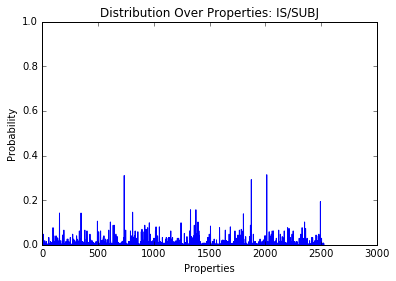

In [585]:
plt.plot(infer_unknown_properties('be', feed_obj_cohort, argtype='subj', prt=0))
plt.title("Distribution Over Properties: IS/SUBJ")
plt.xlabel("Properties")
plt.ylabel("Probability")
plt.ylim(0,1)
plt.show()

## V. Bayesian Update

In [588]:
from scipy.stats import entropy

In [616]:
class Update: # assuming all the previous functions and training.
    
    def __init__(self, word):
        self.word = word
        self.w_propdist = np.ones(len(feature_list)) / len(feature_list) # initialize with uniform.
    
    def update(self, pred, argtype):
        cohort = get_cohort(dep_triples, pred, argtype)
        inferred_propdist = infer_unknown_properties(pred, cohort, argtype)
        new_propdist = self.w_propdist * inferred_propdist # np.array * list = np.array
        self.w_propdist = new_propdist / new_propdist.sum()
    
    def top_k_properties(self, topk=5):
        topk_props_idx = np.argsort(self.w_propdist)[::-1][:topk]
        print "Word: %s" % self.word
        print
        for i,idx in enumerate(topk_props_idx):
            print "%dth Property: %s (prob=%.6f%%,idx=%d)" % (i+1,feature_list[idx],self.w_propdist[idx],idx)
    
    def plot_propdist(self):
        plt.plot(self.w_propdist)
        plt.title("Distribution Over Properties: %s" % self.word)
        plt.xlabel("Properties")
        plt.ylabel("Probability")
        plt.ylim(0.0,0.5)
        plt.show()
        
    def compute_entropy(self):
        ent = entropy(self.w_propdist)
        print "Current Entropy: %.6f" % ent

### E.G. 'alligator' (Multiple Exposure: Bayesian Update)

* Three Levels of Informativeness (can be generalized to all kinds of dependencies, now restricted to core argument structure): 
    * i) Informative: Subj/Obj (wrt. pred) gives specific information.
    * ii) Uninformative: Generally applicable information.
    * iii) Noninformative: Not a core argument.

* Informative Sentences:
    * a. *John had the opportunity to **feed** an **alligator** at the Miami Zoo.*
    * b. *The hunters were able to **catch** a 9-feet giant **alligator**.*
    * c. *An enormous group of **alligators** used to **roam** this region.*
* Uninformative Sentences:
    * a. *The **alligator** **is** a big star in these parts.*
    * b. ***Alligators** **have** the strong teeth that can tear through their way into people's houses.*
    * c. *Ryan **got** an **alligator** for birthday gift.*
* Noninformative Sentences:
    * I.e. Word **alligator** not found in core-argument positions.

** Informative Sentences **:
* a: pred = feed; argtype = obj
* b: pred = catch; argtype = obj
* c: pred = roam; argtype = subj

In [617]:
alligator_model = Update('alligator')

Word: alligator

1th Property: has_4_legs (prob=0.039604%,idx=1508)
2th Property: has_a_tail (prob=0.039604%,idx=333)
3th Property: an_animal (prob=0.039604%,idx=931)
4th Property: is_edible (prob=0.029703%,idx=1493)
5th Property: has_legs (prob=0.029703%,idx=2199)


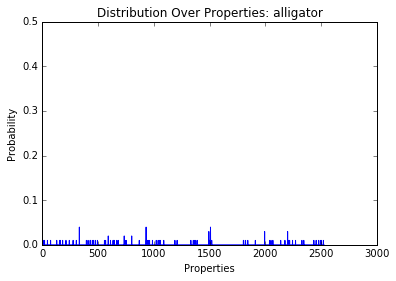

Current Entropy: 4.311339
CPU times: user 4.96 s, sys: 33.6 ms, total: 5 s
Wall time: 4.98 s


In [618]:
%%time
alligator_model.update(pred='feed', argtype='obj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()

Word: alligator

1th Property: has_4_legs (prob=0.131148%,idx=1508)
2th Property: an_animal (prob=0.131148%,idx=931)
3th Property: is_large (prob=0.065574%,idx=735)
4th Property: has_a_tail (prob=0.065574%,idx=333)
5th Property: used_for_transportation (prob=0.065574%,idx=155)


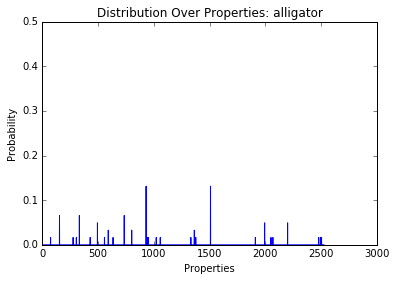

Current Entropy: 3.062464
CPU times: user 4.78 s, sys: 30.4 ms, total: 4.81 s
Wall time: 4.8 s


In [619]:
%%time
alligator_model.update(pred='catch', argtype='obj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()

Word: alligator

1th Property: has_4_legs (prob=0.347826%,idx=1508)
2th Property: an_animal (prob=0.347826%,idx=931)
3th Property: is_large (prob=0.173913%,idx=735)
4th Property: a_mammal (prob=0.086957%,idx=802)
5th Property: is_brown (prob=0.043478%,idx=2477)


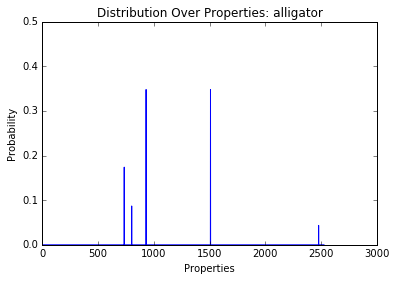

Current Entropy: 1.387558
CPU times: user 3.21 s, sys: 17.9 ms, total: 3.23 s
Wall time: 3.22 s


In [620]:
%%time
alligator_model.update(pred='roam', argtype='subj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()

** Uninformative Sentences **:
* a: pred = be; argtype = subj
* b: pred = have; argtype = obj
* c: pred = get; argtype = obj

In [621]:
alligator_model = Update('alligator')

Word: alligator

1th Property: made_of_wood (prob=0.021565%,idx=2012)
2th Property: is_large (prob=0.021314%,idx=735)
3th Property: made_of_metal (prob=0.020060%,idx=1874)
4th Property: is_small (prob=0.013290%,idx=2493)
5th Property: has_doors (prob=0.010782%,idx=1377)


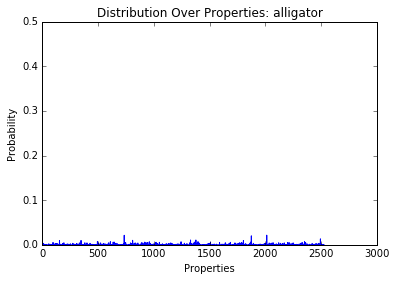

Current Entropy: 6.046351
CPU times: user 3.08 s, sys: 39.9 ms, total: 3.12 s
Wall time: 3.1 s


In [622]:
%%time
alligator_model.update(pred='be', argtype='subj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()

Word: alligator

1th Property: made_of_metal (prob=0.114812%,idx=1874)
2th Property: made_of_wood (prob=0.093631%,idx=2012)
3th Property: is_large (prob=0.067303%,idx=735)
4th Property: is_small (prob=0.052457%,idx=2493)
5th Property: different_colours (prob=0.052111%,idx=348)


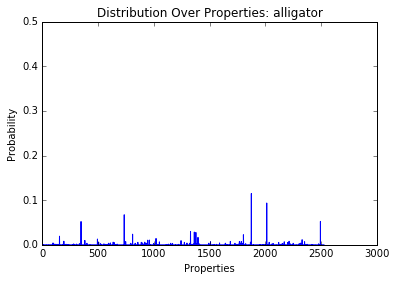

Current Entropy: 4.170214
CPU times: user 4.53 s, sys: 21.2 ms, total: 4.55 s
Wall time: 4.54 s


In [623]:
%%time
alligator_model.update(pred='have', argtype='obj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()

Word: alligator

1th Property: made_of_metal (prob=0.262367%,idx=1874)
2th Property: made_of_wood (prob=0.124813%,idx=2012)
3th Property: different_colours (prob=0.089312%,idx=348)
4th Property: is_small (prob=0.059937%,idx=2493)
5th Property: is_large (prob=0.051267%,idx=735)


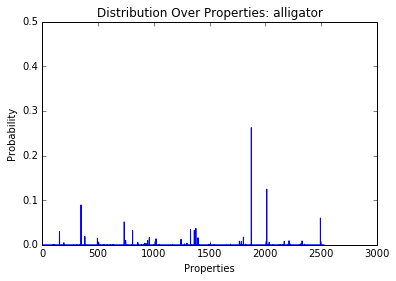

Current Entropy: 2.953485
CPU times: user 4.79 s, sys: 50.4 ms, total: 4.84 s
Wall time: 4.81 s


In [624]:
%%time
alligator_model.update(pred='get', argtype='obj')
alligator_model.top_k_properties()
alligator_model.plot_propdist()
alligator_model.compute_entropy()